In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier as XGB
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm

import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import keras.layers as Layers

import warnings
warnings.filterwarnings("ignore")

In [2]:
dir_path = './dataset/'   
csv_path = './mldata.csv'
np_dir = './np_arrays/'
final_dataset = './final_dataset/'

f_start = 101
f_end = 639
data_3d = []
labels_df = pd.read_csv(csv_path)

labels = []

In [3]:
labels = []

for i in range(len(labels_df)):
    crackles = labels_df['crackles'][i]
    wheezes = labels_df['wheezes'][i]
    if crackles==0 and wheezes==0:
        labels.append(0)
    elif crackles and wheezes:
        labels.append(3)
    elif crackles==0 and wheezes!=0:
        labels.append(2)
    elif crackles!=0 and wheezes==0:
        labels.append(1)
    else:
        labels.append(-1)

labels_df['class'] = labels
labels_df.to_csv(csv_path)

labels_df.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,patient,crackles,wheezes,class
0,0,0,0,0,101,0,11,2
1,1,1,1,1,102,0,0,0
2,2,2,2,2,103,0,5,2
3,3,3,3,3,104,0,2,2
4,4,4,4,4,105,0,0,0


In [4]:
data_3d = []                                                                    # ran ~ 3 min 30 secs

for patient in range(f_start,f_end+1):
    row = np.load(final_dataset+str(patient)+'.npy')
    data_3d.append(row)

df = pd.DataFrame({'patient':labels_df['patient'], 'features':data_3d, 'class':labels_df['class']})
df.head()

,patient,features,class
0,101,"[[0.0, 0.0, 0.0, -445.4117431640625, 0.0, 0.0,...",2
1,102,"[[0.0, 0.06982729583978653, 1210.0703042453297...",0
2,103,"[[6.0, 0.045263104140758514, 1065.740239889393...",2
3,104,"[[0.0, 0.059741515666246414, 1219.916053818355...",2
4,105,"[[0.0, 0.0, 0.0, -424.20928955078125, 0.0, 0.0...",0


In [5]:
X = np.asarray(data_3d)
Y = np.asarray(labels_df['class'])

X_train, X_test, Y_train, Y_test = tts(X,Y, test_size=0.3, random_state=42)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

In [6]:
OneHot = sklearn.preprocessing.OneHotEncoder()

OneHot.fit(np.reshape(Y_train, (-1,1)))

Y_train_OH = OneHot.transform(np.reshape(Y_train, (-1,1))).toarray()
Y_test_OH = OneHot.transform(np.reshape(Y_test, (-1,1))).toarray()
Y_OH = OneHot.transform(np.reshape(Y, (-1,1))).toarray()

Y_train_OH

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

# BILSTM models


In [7]:
input1 = tf.keras.Input(shape=(862,47))
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.01,recurrent_dropout=0.03))(input1)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(512, activation="relu")(x2)
x5 = tf.keras.layers.Dense(256, activation="relu")(x3)
output1 = tf.keras.layers.Dense(4, activation="sigmoid")(x5)
model1 =keras.Model(inputs=input1, outputs=[output1])

model1.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0001), metrics=['accuracy'])
model1.summary()

tf.keras.utils.plot_model(model1, "model1.png",show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 862, 47)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 862, 128)         57344     
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 110336)            0         
                                                                 
 dense (Dense)               (None, 512)               56492544  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                             

In [8]:
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        super(attention,self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)


input2 = tf.keras.Input(shape=(862,47))
xx1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,input_shape=(None,862,47),return_sequences=True, dropout=0.2,recurrent_dropout=0.1))(input2)
xx2 = tf.keras.layers.Flatten()(xx1)
xx2 = tf.keras.layers.Dense(512, activation="relu")(xx2)
xx3 = tf.keras.layers.Dense(128, activation="relu")(xx2)
# xx4 = attention(return_sequences=True)(xx3)
xx4 = tf.keras.layers.Attention()([xx3,xx3])
out2=tf.keras.layers.Dense(4, activation="sigmoid")(xx4)

model2 =keras.Model(inputs=input2, outputs=out2)

model2.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0005), metrics=['accuracy'])
model2.summary()

tf.keras.utils.plot_model(model2, "model2.png",show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 862, 47)]    0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 862, 16)     3584        ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 flatten_1 (Flatten)            (None, 13792)        0           ['bidirectional_1[0][0]']        
                                                                                                  
 dense_3 (Dense)                (None, 512)          7062016     ['flatten_1[0][0]']        

In [9]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

# Model3: BI-LSTM-XGBOOST

In [11]:
input3 = tf.keras.Input(shape=(862,47))
z1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.03))(input3)
z2 = tf.keras.layers.Flatten()(z1)
z3 = tf.keras.layers.Dense(256, activation="relu")(z2)
z5 = tf.keras.layers.Dense(64, activation="relu")(z3)
output3 = tf.keras.layers.Dense(4, activation="softmax")(z5)
model3 =keras.Model(inputs=input3, outputs=[z3,output3])

model3.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0001), metrics=['accuracy'])
model3.summary()

tf.keras.utils.plot_model(model3, "model3.png",show_shapes=True)

history = model1.fit(X_train, Y_train_OH,
                    batch_size = 32,
                    epochs = 15,
                    verbose = 2,
                    validation_split = 0.2)

loss, accuracy = model1.evaluate(X, Y_OH, batch_size = 32, verbose=2)
print(f'test accuracy : ',accuracy)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 862, 47)]         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 862, 128)         57344     
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 110336)            0         
                                                                 
 dense_9 (Dense)             (None, 256)               28246272  
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                           

In [12]:
features_xgb = model3(X_train)[0]
xgb_model = XGB()
xgb_model.fit(features_xgb, Y_train)
features_test = model3(X_test)[0]
ypreds = xgb_model.predict(features_test)

print(metrics.accuracy_score(Y_test, ypreds))

0.2962962962962963


# Training

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.39474, saving model to ./dataset\weights.h5
10/10 - 12s - loss: 1.0710 - accuracy: 0.5880 - val_loss: 1.3398 - val_accuracy: 0.3947 - 12s/epoch - 1s/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.39474
10/10 - 11s - loss: 1.0582 - accuracy: 0.6412 - val_loss: 1.3395 - val_accuracy: 0.3947 - 11s/epoch - 1s/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.39474
10/10 - 11s - loss: 1.0598 - accuracy: 0.6013 - val_loss: 1.3439 - val_accuracy: 0.3421 - 11s/epoch - 1s/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.39474
10/10 - 11s - loss: 1.0610 - accuracy: 0.5980 - val_loss: 1.3454 - val_accuracy: 0.3553 - 11s/epoch - 1s/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.39474
10/10 - 11s - loss: 1.0473 - accuracy: 0.5980 - val_loss: 1.3389 - val_accuracy: 0.3684 - 11s/epoch - 1s/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.39474
10/10 - 12s - loss: 1.0539 - accu

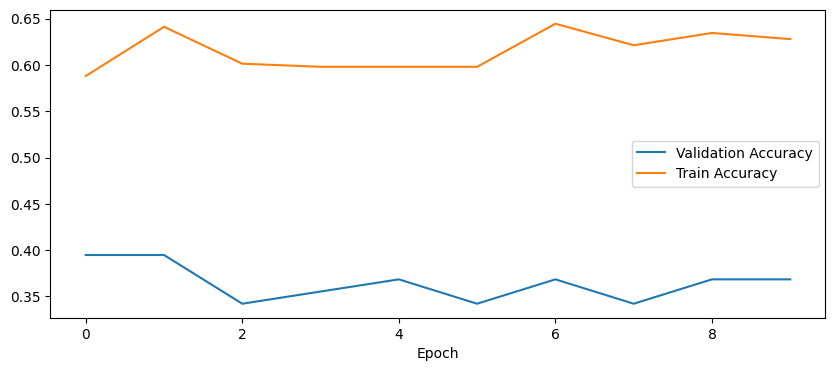

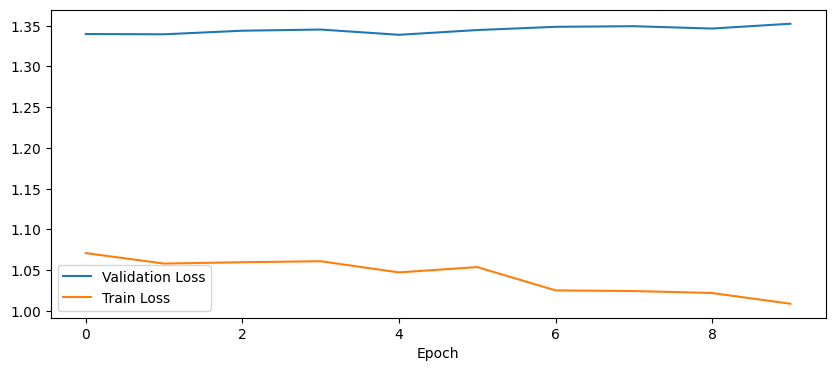

In [13]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(dir_path+'weights.h5', monitor='val_accuracy', save_best_only=True, verbose=2)

history = model1.fit(X_train, Y_train_OH,
                    batch_size = 32,
                    epochs = 10,
                    verbose = 2,
                    validation_split = 0.2,callbacks=[checkpoint])

loss, accuracy = model1.evaluate(X, Y_OH, batch_size = 32, verbose=2)



print('\n\nTest loss:', loss)
print('Test accuracy:', accuracy)

dff = pd.DataFrame(history.history)
plt.figure(figsize=(10,4))
plt.plot(range(len(dff['val_accuracy'])), dff['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(dff['accuracy'])), dff['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(len(dff['val_loss'])), dff['val_loss'], label='Validation Loss')
plt.plot(range(len(dff['loss'])), dff['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

In [14]:
def eval(model1, X, Y):
    preds = model1.predict(X)
    preds = np.array([np.argmax(i) for i in preds])
    print(preds)
    print(Y)
    print(metrics.accuracy_score(Y, preds))
    print()

eval(model2, X_train, Y_train)
eval(model2, X_test, Y_test)

12/12 [==============================] - 2s 91ms/step
[2 3 3 3 3 3 3 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 2 3 3 3 2 3 2 2 3
 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 2 3 3 3 2 2 3 3 2 3 3 3 3 3 3 3
 2 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 2 3 3 3 3 3 2 3 3 2 2 2 3 3 2 3 3 3
 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 2 3 3 3 3 2 2 2 3 3 3 2 3 3 3 3 2 3 2
 3 2 3 3 3 2 3 3 2 2 3 2 3 3 3 3 3 2 3 3 3 2 3 3 2 3 2 3 2 2 2 2 2 3 2 3 3
 3 3 3 3 2 2 3 3 3 3 3 3 2 2 3 2 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3
 3 3 3 3 3 2 3 3 3 3 3 2 3 2 3 3 2 3 3 3 2 3 2 2 2 3 2 2 2 3 3 3 3 3 3 2 3
 3 2 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 2 3 3 2 2 3 2 3 2 3 3 3 2 3 3 3 3 3 3 3 3 3 3 2 3 3 2 2 3 3
 3 2 2 3 3 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 2]
[1 1 0 3 1 0 3 0 0 1 0 1 3 1 1 3 0 0 0 1 2 0 0 0 0 2 2 3 3 3 2 1 1 0 1 3 1
 3 3 3 0 3 0 0 3 1 3 0 1 1 2 2 3 1 1 0 2 1 0 1 1 0 0 0 1 0 1 3 3 0 1 3 1 0
 0 1 0 1 2 3 2 1 2 2 0 3 0 0 0